### Imports

In [11]:
import scipy as sci
from scipy import stats
from scipy.special import expit
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib widget


### Read Data

In [2]:
file = 'examen.csv'
data = pd.read_csv(file, index_col=None, header=None).reset_index(drop=True)
N_S = len(data.index)
indices = data.index

### Preprocess

In [41]:
def set_axis_labels(ax, x, y, z):
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    
X_S = data.iloc[:, :3]

def normalize(points):
    min = points.min(axis=0)
    scale = points.max(axis=0) - min
    def denormalize(points):
        return points * scale + min
    return (points - min) / scale, denormalize

X_S, denormalize = normalize(X_S)
X_S, Y_S = X_S.iloc[:, :2], X_S.iloc[:, 2]

def label_to_int(data):
    labels = data.unique()
    label_map = dict(zip(labels, range(len(labels))))
    return data.apply(lambda x: label_map[x]), labels

#Y_S, labels = label_to_int(Y_S)

                0         1
0    0.000000e+00  0.065486
1    0.000000e+00  0.067190
2    3.129944e-08  0.068910
3    9.469850e-08  0.070630
4    1.910228e-07  0.072365
..            ...       ...
896  9.979831e-01  0.003471
897  9.984771e-01  0.002603
898  9.990121e-01  0.001730
899  9.995061e-01  0.000862
900  1.000000e+00  0.000000

[901 rows x 2 columns]
0      0.000000e+00
1      0.000000e+00
2      1.946091e-15
3      0.000000e+00
4      0.000000e+00
           ...     
896    9.939907e-01
897    9.955076e-01
898    9.969662e-01
899    9.984831e-01
900    1.000000e+00
Name: 2, Length: 901, dtype: float64


### Learner measures

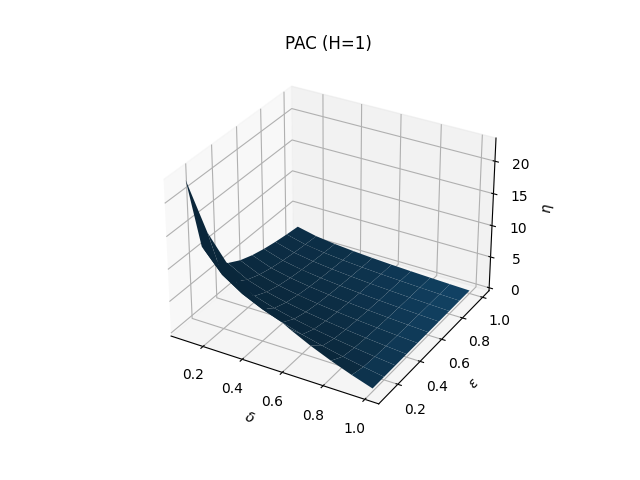

In [47]:
# lower bound to sample size
from turtle import title


def PAC_eta(H_norm, delta, epsilon):
    return (np.log(H_norm) - np.log(delta))/epsilon

# lower bound to generalization error
def PAC_delta(H_norm, epsilon, eta):
    return H_norm/np.exp(eta*epsilon)

H = 1
plt.figure()
X = Y = np.linspace(0.1, 1, 10)
X, Y = np.meshgrid(X, Y)
ax = plt.axes(projection='3d', title=f'PAC (H={H})')
ax.plot_surface(X, Y, PAC_eta(H, X, Y))
set_axis_labels(ax, '$\\delta$', '$\\varepsilon$', '$\\eta$')
#print(X,Y)


# Sampling

##### Distributions

Text(0.5, 0, 'Sample Index')

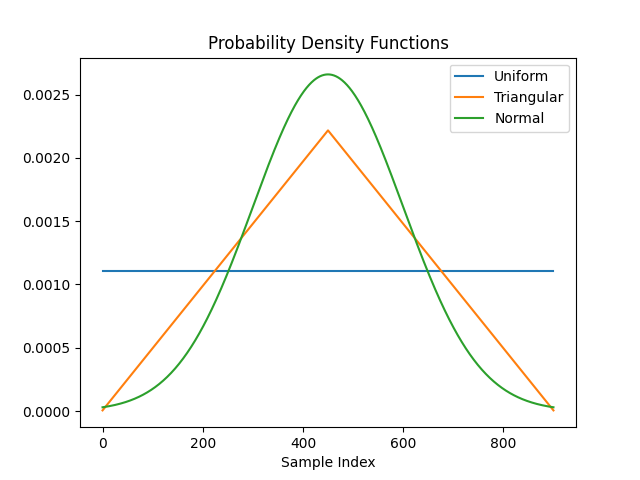

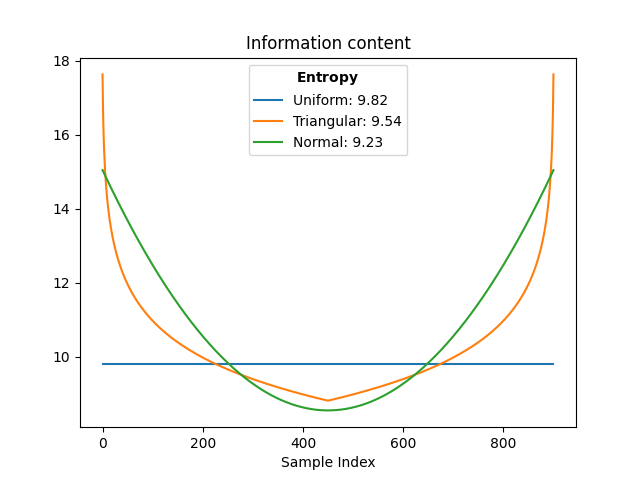

In [5]:
pdf_names = ["Uniform", "Triangular", "Normal"]


def pdf(pdf, x, N):
    return pd.Series(dict(zip(pdf_names, [
        sci.stats.uniform.pdf(x, 0, N),
        sci.stats.triang.pdf(x, 0.5, -1, N+1),
        sci.stats.norm.pdf(x, N//2, N//6)])
        )[pdf], index=x)


plt.figure()
for name in pdf_names:
    F = pdf(name, indices, N_S)
    plt.plot(indices, F, label=name)
plt.legend()
plt.title("Probability Density Functions")
plt.xlabel("Sample Index")

plt.figure()
for name in pdf_names:
    F = pdf(name, indices, N_S)
    I = np.log2(1/F)
    H = np.sum(-F*np.log2(F))
    plt.plot(indices, I, label=f"{name}: {H:.2f}")
plt.legend(title="$\\bf{Entropy}$")
plt.title("Information content")
plt.xlabel("Sample Index")


##### Comparison of samples

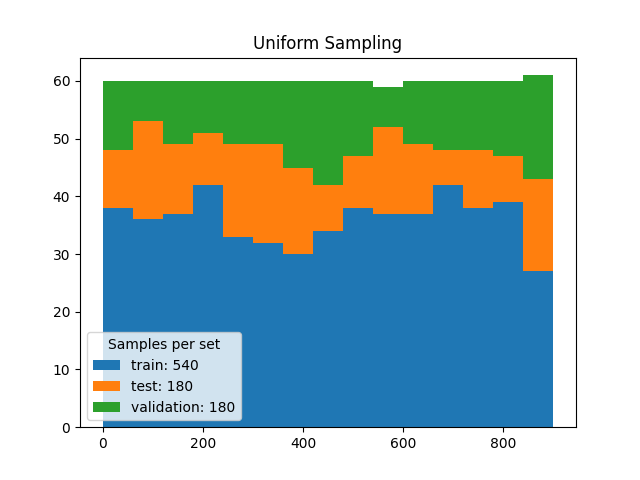

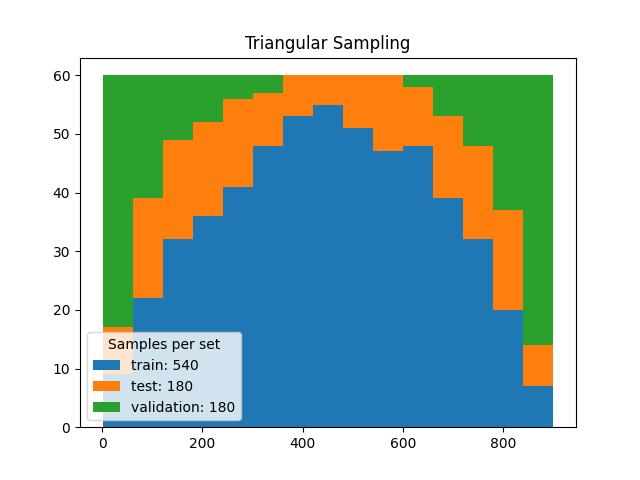

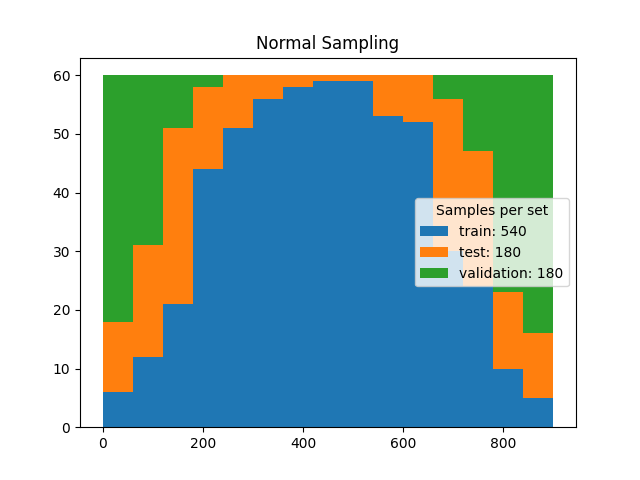

In [6]:
sets = {"train": int(0.6*N_S),
        "test": int(0.2*N_S),
        "validation": int(0.2*N_S)}

sets_uniform = sets.copy()

for name in pdf_names:
    weights = pdf(name, indices, N_S)
    sets_curr = sets.copy()
    plt.figure()
    ax = plt.axes(title=f"{name} Sampling")
    
    for k, v in sets_curr.items():
        X_sample = X_S.iloc[weights.index, :2].sample(n=v, weights=weights)
        if name == "Uniform":
            sets_uniform[k] = (X_sample, Y_S.iloc[X_sample.index])
        weights = weights.drop(X_sample.index)
        sets_curr[k] = X_sample.index

    ax.hist(sets_curr.values(), stacked=True, bins=15,
        label=[f"{k}: {len(v)}" for k, v in sets_curr.items()])    
    plt.legend(title="Samples per set")

# Supervised Learning

### Neural Network

##### Definition

In [7]:
def to_vector(Y, cats):
    id = np.identity(cats)
    return np.array([id[c, :] for c in Y])
    
def update(X, Yd, W, B, phi, dphi):
    p = X.shape[1]

    # feedforward
    V = [None] * (k+1)
    Y = [None] * (k+1)
    Y[0] = X
    for l in range(1, k+1):
        V[l] = W[l] @ Y[l-1]
        if B != None:
            V[l] += B[l]
        Y[l] = phi(V[l])
    #softmax = lambda x: np.exp(x) / sum(np.exp(x))
    #dsoftmax = lambda x: np.diag(softmax(x).flatten()) @ (np.eye(x.shape[0]) - softmax(x))

    # backpropagation
    dE = Y[k] - Yd
    E = np.diag((Y[k] - Yd).T @ (Y[k] - Yd))/2

    delta = [None] * (k+1)
    delta[k] = dE * dphi(V[k])
    for l in reversed(range(1, k)):
        delta[l] = (W[l+1].T @ delta[l+1]) * dphi(V[l])

    # update
    for l in range(1, k+1):
        W[l] -= (delta[l] @ Y[l-1].T) / p
        if B != None:
            B[l] -= (delta[l] @ np.ones((p, 1))) / p
    return W, B, delta, E


##### Run

In [8]:
X, Yd = sets_uniform["train"]
X, Yd = X.to_numpy().T, Yd.to_numpy()[:, None].T
X_test, Y_test = sets_uniform["test"]
X_test, Y_test = X_test.to_numpy().T, Y_test.to_numpy().T

neurons = [X.shape[0], 2, 2, Yd.shape[0]]
k = len(neurons) - 1
epochs = 1000

np.random.seed(69)
W = [None] * (k+1)
B = [None] * (k+1)
for l in range(1, k+1):
    W[l] = np.random.randn(neurons[l], neurons[l-1])
    B[l] = np.random.randn(neurons[l])[:, None]
phi = expit
def dphi(x): return phi(x) * (1 - phi(x))

deltas = []
errors = {"train": [],
          "test": [],
          "validation": []}
ys = []
for i in range(epochs):
    W, B, delta, E = update(X, Yd, W, B, phi, dphi)
    deltas.append([np.mean(sum(np.abs(delta[l]))) for l in range(1, k+1)])
    errors["train"].append(sum(E)/X.shape[1])
    Y_last = X_test
    for l in range(1, k+1):
        V_last = W[l] @ Y_last + B[l]
        Y_last = phi(V_last)
    E = np.diag((Y_last - Y_test).T @ (Y_last - Y_test))/2
    errors["test"].append(sum(E)/Y_last.shape[1])
    ys.append([Y_last])

deltas = np.array(deltas).T

##### Graphs

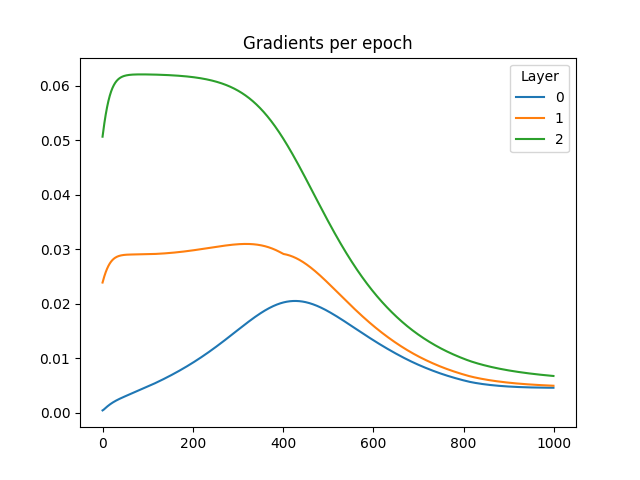

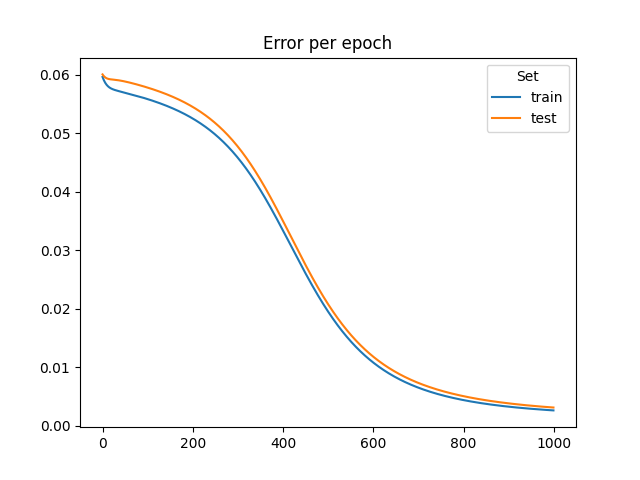

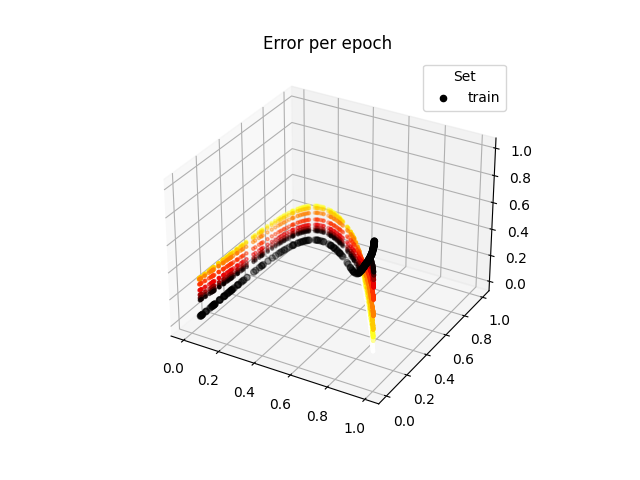

In [33]:
plt.figure()
ax = plt.axes(title=f"Gradients per epoch")
ax.plot(range(epochs), deltas.T, label=range(deltas.shape[0]))
ax.legend(title="Layer")

plt.figure()
ax = plt.axes(title=f"Error per epoch")
ax.plot(range(epochs), errors["train"], label="train")
ax.plot(range(epochs), errors["test"], label="test")
plt.legend(title="Set")

plt.figure()
color = plt.cm.hot(np.linspace(0,1,10))
ax = plt.axes(projection="3d", title=f"Error per epoch")
ax.scatter(X_test[0, :], X_test[1, :], Y_test, label="train", color = 'black')
for c, k in enumerate(range(0, len(ys), len(ys)//10)):
    ax.scatter(X_test[0, :], X_test[1, :], ys[k][0], color = color[9-c])
plt.legend(title="Set")